# Baseline Sentiment Analysis
Sentiment analysis of Indonesian online marketplace app reviews.

Steps:
1. EDA and data cleaning
2. Baseline model using traditional machine learning

## Loading Dependencies

In [1]:
import re

import pandas as pd

# Visualization
import seaborn as sns

# Google cloud
from google.oauth2 import service_account
from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

2022-01-08 03:04:21.709576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-08 03:04:21.709632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
key_path = '../airflow/credentials/future-data-track-1-sapporo.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path,
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

bigquery_client = bigquery.Client(
    project='future-data-track-1',
    credentials=credentials
)

In [3]:
query = """
WITH t AS (
  SELECT *
  FROM `future-data-track-1.sapporo_mart.sentiment_analysis`
),
table_stats AS (
  SELECT *, SUM(c) OVER() total 
  FROM (
    SELECT sentiment, COUNT(*) c 
    FROM t
    GROUP BY 1 
    HAVING c>100000)
)
SELECT sample.*
FROM (
SELECT ARRAY_AGG(a ORDER BY RAND() LIMIT 40000) cat_samples, sentiment, ANY_VALUE(c) c
FROM t a
JOIN table_stats b
USING(sentiment)
GROUP BY sentiment
), UNNEST(cat_samples) sample WITH OFFSET off;
"""

query_job = bigquery_client.query(query)
df = query_job.to_dataframe()

In [4]:
df.head()

,review,rating,sentiment
0,Josss,5,2
1,Keren,5,2
2,Muraha,5,2
3,Lumauan memuaskan barang murah tp terjaminnn b...,5,2
4,Sangat membantu dalam jual beli,5,2


## 1. EDA and cleaning

/home/dionrickysptr/future-data-2/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

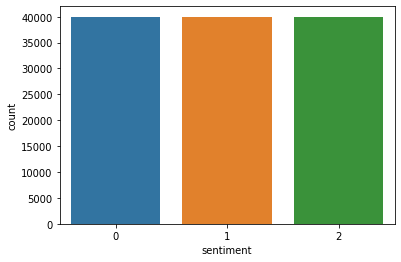

In [5]:
sns.countplot(df["sentiment"])

In [6]:
df.isna().sum()

review       1
rating       0
sentiment    0
dtype: int64

In [7]:
df = df.dropna(axis=0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119999 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     119999 non-null  object
 1   rating     119999 non-null  int64 
 2   sentiment  119999 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.7+ MB


### Cleaning

In [9]:
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    texts = texts.lower()

    return texts

In [10]:
df['review_cleaned'] = df['review'].apply(lambda x : preprocessing_text(x))

In [11]:
df.head()

,review,rating,sentiment,review_cleaned
0,Josss,5,2,josss
1,Keren,5,2,keren
2,Muraha,5,2,muraha
3,Lumauan memuaskan barang murah tp terjaminnn b...,5,2,lumauan memuaskan barang murah tp terjaminnn b...
4,Sangat membantu dalam jual beli,5,2,sangat membantu dalam jual beli


In [12]:
word_length = []
for row in df['review_cleaned']:
    word_length.append(len(row))

display(pd.DataFrame(word_length, columns=['word_length']).describe())
display(pd.DataFrame(word_length, columns=['word_length']).quantile(0.90))

,word_length
count,119999.000000
mean,68.827582
std,86.776979
min,1.000000
25%,12.000000
50%,37.000000
75%,90.000000
max,1232.000000


word_length    175.0
Name: 0.9, dtype: float64

## 2. Baseline model

/home/dionrickysptr/future-data-2/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.70      0.68      0.69     10052
           1       0.57      0.53      0.55      9975
           2       0.73      0.80      0.76      9973

    accuracy                           0.67     30000
   macro avg       0.67      0.67      0.67     30000
weighted avg       0.67      0.67      0.67     30000



<AxesSubplot:>

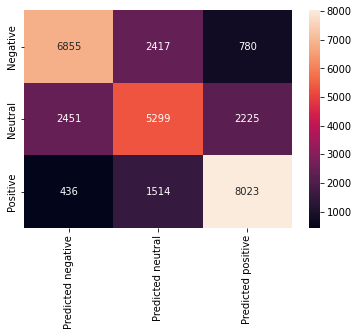

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['review_cleaned'], df['sentiment'])
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                    ('lr_clf', LogisticRegression())])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), 
            annot=True, fmt='.0f', 
            xticklabels=['Predicted negative', 'Predicted neutral', 'Predicted positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])